In [82]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import *

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from datetime import datetime, date
import openpyxl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [76]:
dataset = pd.read_excel('./data/carddata3.xlsx', engine="openpyxl")

In [78]:
dataset = dataset[dataset['HKONT'] != 54010901]
dataset = dataset[dataset['HKONT'] != 54010817]
dataset = dataset[dataset['HKONT'] != 54011603]

In [79]:
t = dataset['HKONT']
t.value_counts()

54010801    17476
54010802    11518
54011701     6142
54011901     5983
54011403     4556
54010902     1635
54011903     1334
54011905      943
54012618      696
54011405      682
Name: HKONT, dtype: int64

In [80]:
dataset.columns=["APPR_NO", "MCC_CODE", "MCC_NAME", "ACQ_CLASS", "APPR_DATE", "APPR_TIME", "MERCH_ADDR", "MERCH_NAME", "ABOARD", "APPR_AMT","TIPS","ACQU_FEE", "VAT", "ETC1", "ETC3", "CRD_FG_CD", "CRD_STL_DD", "EMP_NO", "EMP_DV_CD", "GRADE_CD", "TITLE_CD", "BP_CD", "BA_CD", "HKONT", "ACCT_NM"]
dataset = dataset.astype({'MCC_CODE': 'object', 'ETC3': 'object', 'TITLE_CD':'object', 'CRD_STL_DD':'object','BA_CD':'object' ,'HKONT': 'object'})
dataset = dataset.dropna(axis=0).reset_index()

for index, row in dataset.iterrows():
    if dataset["MERCH_ADDR"][index].isalpha():
        dataset["MERCH_ADDR"][index] = "Foreign"
    else:
        dataset["MERCH_ADDR"][index] = dataset["MERCH_ADDR"][index].split(" ")[1]

In [83]:
new_data = pd.DataFrame()
label_onehot = pd.DataFrame()
label_label = pd.DataFrame()
cate_col = ["MCC_CODE","MERCH_ADDR","ABOARD","ETC1","ETC3","CRD_FG_CD","CRD_STL_DD","TITLE_CD","BA_CD", "HKONT"]
day_week_array = []
day_range_array = []
time_range_array = []

# 금액 데이터 처리
appr_amt = np.array(dataset["APPR_AMT"]).reshape(-1, 1)
vat = np.array(dataset["VAT"]).reshape(-1, 1)
ss_amt=StandardScaler().fit_transform(appr_amt)
ss_vat=StandardScaler().fit_transform(vat)
reg_amt=MinMaxScaler().fit_transform(appr_amt)
reg_vat=MinMaxScaler().fit_transform(vat)
ss_amt_frame = pd.DataFrame(ss_amt)
ss_vat_frame = pd.DataFrame(ss_vat)
reg_amt_frame = pd.DataFrame(reg_amt)
reg_vat_frame = pd.DataFrame(reg_vat)

new_data = pd.concat([new_data, ss_amt_frame], axis=1)
new_data = pd.concat([new_data, ss_vat_frame], axis=1)
#new_data = pd.concat([new_data, reg_amt_frame], axis=1)
#new_data = pd.concat([new_data, reg_vat_frame], axis=1)
#new_data = pd.concat([new_data, dataset["APPR_AMT"]], axis=1)
#new_data = pd.concat([new_data, dataset["VAT"]], axis=1)

# 날짜 데이터 처리
datatemp = pd.DataFrame(dataset["APPR_DATE"])
for index, row in datatemp.iterrows():
    temp_year  = int(str(dataset["APPR_DATE"][index])[0:4])
    temp_month = int(str(dataset["APPR_DATE"][index])[4:6])
    temp_day   = int(str(dataset["APPR_DATE"][index])[6:8])
    day = date(temp_year, temp_month, temp_day).weekday()

    if temp_day < 10:
        range_day = 0
    elif temp_day >= 10 and temp_day < 20:
        range_day = 1
    else:
        range_day = 2    
        
    day_week_array.append(day)
    day_range_array.append(range_day)

new_data = pd.concat([new_data, pd.DataFrame(day_week_array)], axis=1)
new_data = pd.concat([new_data, pd.DataFrame(day_range_array)], axis=1)

# 시간 데이터 처리
datatemp = pd.DataFrame(dataset["APPR_TIME"])
for index, row in datatemp.iterrows():
    temp_time   = int(str(dataset["APPR_TIME"][index])[0:2])

    if temp_time <10:
        range_time = 0
    elif temp_time >= 10 and temp_time < 14:
        range_time = 1
    elif temp_time >= 14 and temp_time < 18:
        range_time = 2
    else:
        range_time = 3

    time_range_array.append(range_time)    
    
new_data = pd.concat([new_data, pd.DataFrame(time_range_array)], axis=1)    

# categorical data 처리
for col in dataset.columns:
    if col in cate_col:
        if col == 'HKONT':
            le = LabelEncoder()
            le.fit(dataset.HKONT)
            temp = pd.DataFrame(le.transform(dataset.HKONT))
            label_label = pd.concat([label_label, temp], axis = 1)
            
            enc = OneHotEncoder(handle_unknown ='ignore')
            enc.fit(np.array(dataset[col]).reshape(-1,1))
            temp = pd.DataFrame(enc.transform(np.array(dataset[col]).reshape(-1,1)).toarray())
            label_onehot = pd.concat([label_onehot, temp], axis = 1)
        else:
            enc = OneHotEncoder(handle_unknown ='ignore')
            # col_name = enc.get_feature_names([col])
            # encoded = enc.fit_transform(dataset[col])
            # one_hot_encoded_frame = pd.DataFrame(encoded ,columns=col_name)
            enc.fit(np.array(dataset[col]).reshape(-1,1))
            temp = pd.DataFrame(enc.transform(np.array(dataset[col]).reshape(-1,1)).toarray())
            new_data = pd.concat([new_data, temp], axis=1)

In [92]:
new_col_index = np.array(range(1,len(new_data.T)+1),int)
new_data.columns = new_col_index
new_data.head()

,1,2,3,4,5,6,7,8,9,10,...,327,328,329,330,331,332,333,334,335,336
0,0.223239,0.246525,4,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.472689,2.577533,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.257886,0.282356,4,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.086370,-0.074173,0,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.307655,0.334226,3,1,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [93]:
df = pd.concat([new_data,label_label], axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,328,329,330,331,332,333,334,335,336,0
0,0.223239,0.246525,4,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
1,2.472689,2.577533,6,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
2,0.257886,0.282356,4,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
3,-0.086370,-0.074173,0,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.307655,0.334226,3,1,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


<AxesSubplot:xlabel='0', ylabel='count'>

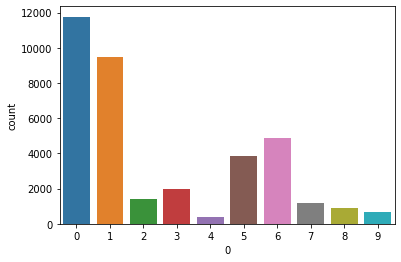

In [95]:
sns.countplot(x = 0, data=df)

In [96]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [97]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [98]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [99]:
def get_class_distribution(obj):
    count_dict = {
        "rating_0": 0,
        "rating_1": 0,
        "rating_2": 0,
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
        "rating_9": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_0'] += 1
        elif i == 1: 
            count_dict['rating_1'] += 1
        elif i == 2: 
            count_dict['rating_2'] += 1
        elif i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1  
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1
        elif i == 8: 
            count_dict['rating_8'] += 1
        elif i == 9: 
            count_dict['rating_9'] += 1
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

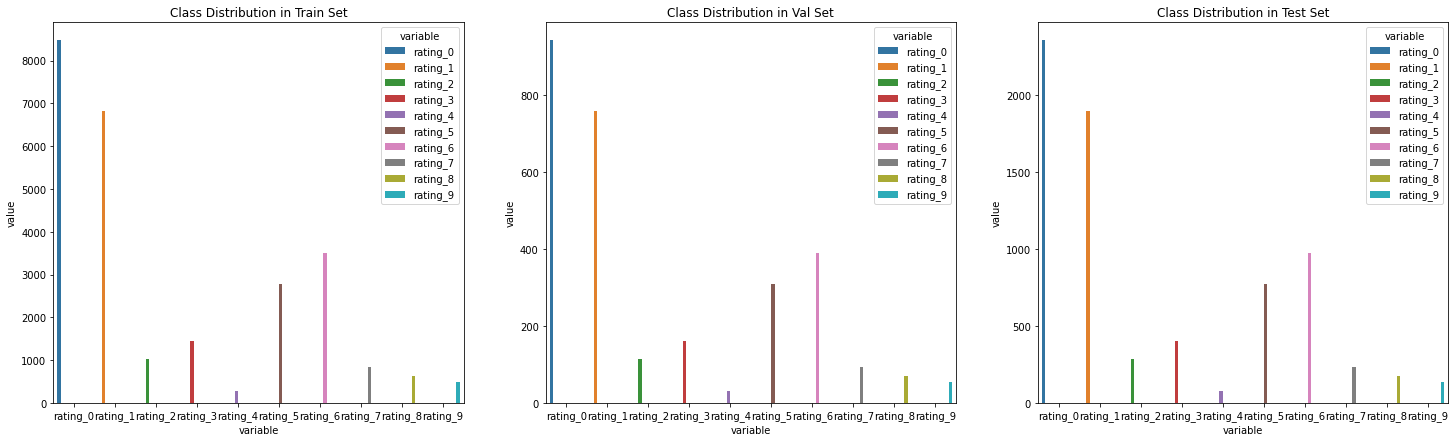

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [101]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [102]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [103]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0001, 0.0001, 0.0010, 0.0007, 0.0036, 0.0004, 0.0003, 0.0012, 0.0016,
        0.0020])


In [104]:
class_weights_all = class_weights[target_list]

In [105]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [106]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 10

In [107]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [108]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [110]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=336, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [111]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [112]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [113]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.23671 | Val Loss: 1.23824 | Train Acc: 50.127| Val Acc: 52.961
Epoch 002: | Train Loss: 0.93446 | Val Loss: 1.15964 | Train Acc: 56.316| Val Acc: 55.255
Epoch 003: | Train Loss: 0.86375 | Val Loss: 1.17091 | Train Acc: 58.479| Val Acc: 55.289
Epoch 004: | Train Loss: 0.81772 | Val Loss: 1.07950 | Train Acc: 60.175| Val Acc: 57.206
Epoch 005: | Train Loss: 0.80725 | Val Loss: 1.11389 | Train Acc: 60.297| Val Acc: 56.693
Epoch 006: | Train Loss: 0.77610 | Val Loss: 1.08293 | Train Acc: 61.010| Val Acc: 57.720
Epoch 007: | Train Loss: 0.74368 | Val Loss: 1.08209 | Train Acc: 61.881| Val Acc: 57.172
Epoch 008: | Train Loss: 0.74224 | Val Loss: 1.11690 | Train Acc: 62.496| Val Acc: 56.933
Epoch 009: | Train Loss: 0.71152 | Val Loss: 1.08523 | Train Acc: 62.596| Val Acc: 58.336
Epoch 010: | Train Loss: 0.68189 | Val Loss: 1.09482 | Train Acc: 64.399| Val Acc: 58.644
Epoch 011: | Train Loss: 0.69271 | Val Loss: 1.07866 | Train Acc: 64.204| Val Acc: 58.747
Epoch 012:

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

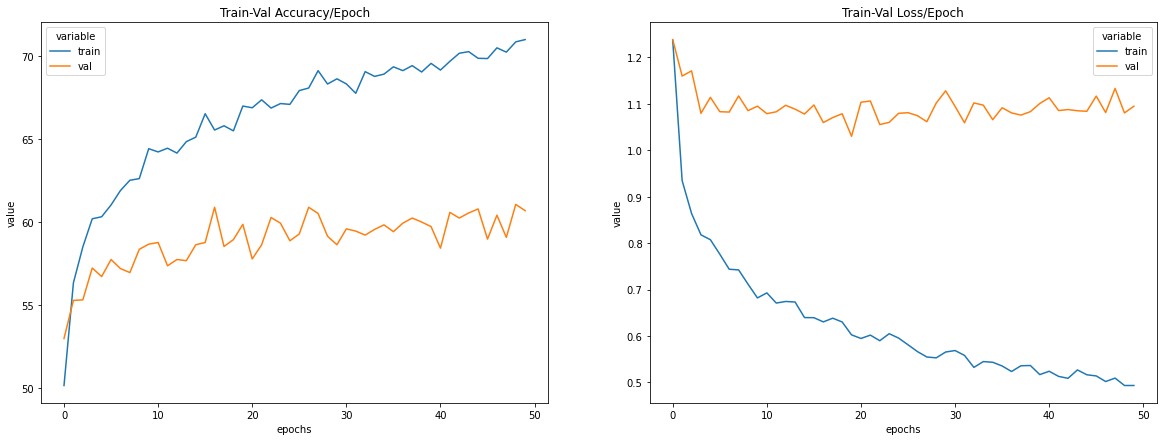

In [115]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [117]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60      2353
           1       0.72      0.57      0.64      1895
           2       0.47      0.66      0.55       286
           3       0.46      0.81      0.59       401
           4       0.25      0.54      0.34        76
           5       0.50      0.60      0.54       773
           6       0.81      0.70      0.75       971
           7       0.44      0.74      0.55       234
           8       0.34      0.73      0.46       175
           9       0.73      0.88      0.80       137

    accuracy                           0.61      7301
   macro avg       0.54      0.68      0.58      7301
weighted avg       0.65      0.61      0.62      7301



In [118]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1024)
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_4 = nn.Linear(256, 128)
        self.layer_5 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.batchnorm5 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)
        
        return x

In [119]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [120]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=336, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=128, bias=True)
  (layer_5): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [121]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [122]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.30831 | Val Loss: 1.25462 | Train Acc: 48.265| Val Acc: 50.873
Epoch 002: | Train Loss: 0.98537 | Val Loss: 1.25007 | Train Acc: 55.311| Val Acc: 53.235
Epoch 003: | Train Loss: 0.92806 | Val Loss: 1.21826 | Train Acc: 56.873| Val Acc: 53.030
Epoch 004: | Train Loss: 0.87149 | Val Loss: 1.12540 | Train Acc: 58.097| Val Acc: 55.289
Epoch 005: | Train Loss: 0.81633 | Val Loss: 1.11476 | Train Acc: 59.854| Val Acc: 54.742
Epoch 006: | Train Loss: 0.80768 | Val Loss: 1.10354 | Train Acc: 60.353| Val Acc: 56.898
Epoch 007: | Train Loss: 0.79942 | Val Loss: 1.14544 | Train Acc: 60.438| Val Acc: 56.488
Epoch 008: | Train Loss: 0.77895 | Val Loss: 1.10096 | Train Acc: 61.311| Val Acc: 56.008
Epoch 009: | Train Loss: 0.72432 | Val Loss: 1.09853 | Train Acc: 62.927| Val Acc: 57.651
Epoch 010: | Train Loss: 0.72322 | Val Loss: 1.11934 | Train Acc: 63.153| Val Acc: 57.069
Epoch 011: | Train Loss: 0.73089 | Val Loss: 1.14727 | Train Acc: 62.998| Val Acc: 55.734
Epoch 012:

In [123]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.71      0.51      0.60      2353
           1       0.73      0.54      0.62      1895
           2       0.38      0.67      0.48       286
           3       0.45      0.81      0.58       401
           4       0.27      0.55      0.37        76
           5       0.48      0.61      0.54       773
           6       0.83      0.68      0.75       971
           7       0.38      0.79      0.51       234
           8       0.35      0.73      0.47       175
           9       0.79      0.91      0.84       137

    accuracy                           0.60      7301
   macro avg       0.54      0.68      0.58      7301
weighted avg       0.66      0.60      0.61      7301

